In [1]:
import os
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import logging

from torchmeta.datasets.helpers import omniglot, doublemnist
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters

In [2]:
import torch.nn as nn
from torchmeta.modules import (MetaModule, MetaSequential, MetaConv2d,
                               MetaBatchNorm2d, MetaLinear)

In [3]:
import matplotlib.pyplot as plt

In [4]:
def conv3x3(in_channels, out_channels, **kwargs):
    return MetaSequential(
        MetaConv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        MetaBatchNorm2d(out_channels, momentum=1., track_running_stats=False),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

In [5]:
class ConvolutionalNeuralNetwork(MetaModule):
    def __init__(self, in_channels, out_features, hidden_size=64):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_features = out_features
        self.hidden_size = hidden_size

        self.features = MetaSequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size)
        )

        self.classifier = MetaLinear(hidden_size, out_features)

    def forward(self, inputs, params=None):
        features = self.features(inputs, params=self.get_subdict(params, 'features'))
        features = features.view((features.size(0), -1))
        logits = self.classifier(features, params=self.get_subdict(params, 'classifier'))
        return logits


In [6]:
from collections import OrderedDict

In [7]:
def get_accuracy(logits, targets):
    """Compute the accuracy (after adaptation) of MAML on the test/query points

    Parameters
    ----------
    logits : `torch.FloatTensor` instance
        Outputs/logits of the model on the query points. This tensor has shape
        `(num_examples, num_classes)`.

    targets : `torch.LongTensor` instance
        A tensor containing the targets of the query points. This tensor has 
        shape `(num_examples,)`.

    Returns
    -------
    accuracy : `torch.FloatTensor` instance
        Mean accuracy on the query points
    """
    _, predictions = torch.max(logits, dim=-1)
    return torch.mean(predictions.eq(targets).float())

In [8]:
class ARGS():
    folder = "data"
    num_shots = 5
    num_ways = 20
    download = True
    batch_size = 16
    num_workers = 0
    hidden_size = 64
    num_batches = 500
    step_size = 0.4
    first_order = False
    
    device = torch.device("cuda")

In [9]:
args = ARGS()

In [10]:
dataset = omniglot(args.folder,
                   shots=args.num_shots,
                   ways=args.num_ways,
                   shuffle=True,
                   #test_shots=15,
                   meta_train=True,
                   download=args.download)

In [11]:
# dataset = doublemnist(args.folder,
#                    shots=args.num_shots,
#                    ways=args.num_ways,
#                    shuffle=True,
#                    meta_train=True,
#                    download=True)

In [12]:
dataloader = BatchMetaDataLoader(dataset,
                                     batch_size=args.batch_size,
                                     shuffle=True,
                                     num_workers=args.num_workers)

In [13]:
for batch in dataloader:
    train_inputs, train_targets = batch["train"]
    print('Train inputs shape: {0}'.format(train_inputs.shape))    # (16, 25, 1, 28, 28)
    print('Train targets shape: {0}'.format(train_targets.shape))  # (16, 25)

    test_inputs, test_targets = batch["test"]
    print('Test inputs shape: {0}'.format(test_inputs.shape))      # (16, 75, 1, 28, 28)
    print('Test targets shape: {0}'.format(test_targets.shape))    # (16, 75)
    break

Train inputs shape: torch.Size([16, 100, 1, 28, 28])
Train targets shape: torch.Size([16, 100])
Test inputs shape: torch.Size([16, 100, 1, 28, 28])
Test targets shape: torch.Size([16, 100])


In [14]:
a = train_inputs[0][1].permute(1,2,0).data.numpy()

In [15]:
train_targets

tensor([[16, 16, 16,  ..., 19, 19, 19],
        [ 5,  5,  5,  ..., 14, 14, 14],
        [16, 16, 16,  ..., 19, 19, 19],
        ...,
        [17, 17, 17,  ...,  6,  6,  6],
        [ 5,  5,  5,  ...,  3,  3,  3],
        [ 9,  9,  9,  ..., 15, 15, 15]])

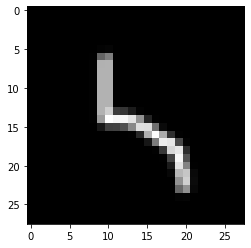

In [16]:
plt.imshow(a, cmap="gray")

In [17]:
model = ConvolutionalNeuralNetwork(1,
                                   args.num_ways,
                                   hidden_size=args.hidden_size)
model.to(device=args.device)
model.train()
meta_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
pretrained_dict = torch.load("10_29.pth")

In [19]:
model_dict = model.state_dict()

In [20]:
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict)

<All keys matched successfully>

In [21]:
# Training loop
acc_list = []
with tqdm(dataloader, total=args.num_batches) as pbar:
     for batch_idx, batch in enumerate(pbar):
            model.zero_grad()

            train_inputs, train_targets = batch['train']
            train_inputs = train_inputs.to(device=args.device)
            train_targets = train_targets.to(device=args.device)

            test_inputs, test_targets = batch['test']
            test_inputs = test_inputs.to(device=args.device)
            test_targets = test_targets.to(device=args.device)

            outer_loss = torch.tensor(0., device=args.device)
            accuracy = torch.tensor(0., device=args.device)
            for task_idx, (train_input, train_target, test_input,
                    test_target) in enumerate(zip(train_inputs, train_targets,
                    test_inputs, test_targets)):
                train_logit = model(train_input)
                inner_loss = F.cross_entropy(train_logit, train_target)

                model.zero_grad()
                params = gradient_update_parameters(model,
                                                    inner_loss,
                                                    step_size=args.step_size,
                                                    first_order=args.first_order)

                test_logit = model(test_input, params=params)
                outer_loss += F.cross_entropy(test_logit, test_target)

                with torch.no_grad():
                    accuracy += get_accuracy(test_logit, test_target)

            outer_loss.div_(args.batch_size)
            accuracy.div_(args.batch_size)

            outer_loss.backward()
            meta_optimizer.step()

            pbar.set_postfix(accuracy='{0:.4f}'.format(accuracy.item()))
            
            acc_list.append(accuracy.item())
            if batch_idx >= args.num_batches:
                break

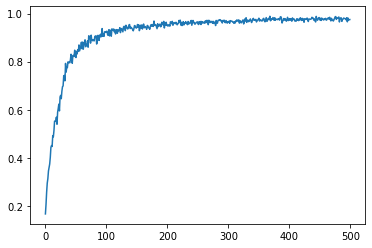

In [22]:
plt.plot(acc_list[:500])
plt.show()

In [23]:
print(acc_list)

[0.16625000536441803, 0.20625001192092896, 0.25687500834465027, 0.2943749725818634, 0.31312498450279236, 0.3449999988079071, 0.3606249988079071, 0.3737500011920929, 0.40187498927116394, 0.4431249797344208, 0.4506250321865082, 0.4468749463558197, 0.4918749928474426, 0.4868749678134918, 0.5131250023841858, 0.5524999499320984, 0.5512499809265137, 0.5531249642372131, 0.5687500238418579, 0.5393750667572021, 0.5893750190734863, 0.6043750047683716, 0.6231249570846558, 0.5950000286102295, 0.653124988079071, 0.6593749523162842, 0.6456249952316284, 0.6768749356269836, 0.6956250071525574, 0.6987499594688416, 0.7406250238418579, 0.7424999475479126, 0.7200000286102295, 0.7924999594688416, 0.7562499046325684, 0.778124988079071, 0.7749999761581421, 0.7987499237060547, 0.7956249713897705, 0.7974998950958252, 0.7950000762939453, 0.8074999451637268, 0.8306249380111694, 0.8181250691413879, 0.7931250333786011, 0.824999988079071, 0.8256250023841858, 0.8212499022483826, 0.8474999666213989, 0.829374969005584